In [ ]:
# Based on the Udacity's Computer Vision Nanodegree project- Facical Keypoint Detection

In [1]:
import sys
import os
sys.path.append("..\\..\\src")

import torch
import torch.optim as optim
import torch.nn as nn

from torchvision import transforms
from dataset_and_augmentations import FacialKeypointsDataset, Rescale, RandomCrop, Normalize, ToTensor
from helper_utils import visualize_output, net_sample_output
from datasets import  dataset_loader
from Model import Net
from model_class import NeuralNet
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
current_path = os.getcwd()
path_to_csv_folder = os.path.join(current_path, 'data')

# Construct the dataset
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

transformed_dataset = FacialKeypointsDataset(csv_file=os.path.join(path_to_csv_folder,'training_frames_keypoints.csv'),
                                             root_dir=os.path.join(path_to_csv_folder,'training'),
                                             transform=data_transform)
# load training data in batches
batch_size = 128

trainloader = dataset_loader(transformed_dataset, batch_size= batch_size , num_workers =4)
train_loader = trainloader.get_dataloader()

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file=os.path.join(path_to_csv_folder,'test_frames_keypoints.csv'),
                                             root_dir=os.path.join(path_to_csv_folder,'test'),
                                             transform=data_transform)

# load test data in batches
batch_size = 10
testloader = dataset_loader(test_dataset, batch_size= batch_size , num_workers =0)
test_loader = testloader.get_dataloader()

In [3]:
nn_model = NeuralNet(Net())
net = nn_model.get_model()
net.to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [4]:
def train_net(n_epochs, net, train_loader):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            images = images.to(device)
            key_pts = key_pts.to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')

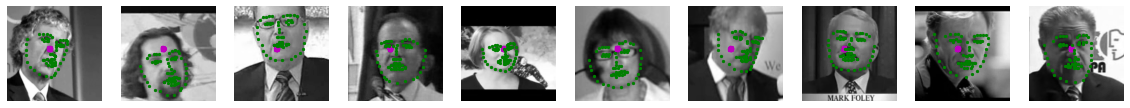

<Figure size 432x288 with 0 Axes>

In [5]:
test_images, test_outputs, gt_pts = net_sample_output(test_loader, net, device)
visualize_output(test_images, test_outputs, gt_pts, phase = 'Before training Predictions')

In [6]:
n_epochs = 40#40 
train_net(n_epochs, net, train_loader)

Epoch: 1, Batch: 10, Avg. Loss: 0.18358590453863144
Epoch: 1, Batch: 20, Avg. Loss: 0.10601437315344811
Epoch: 2, Batch: 10, Avg. Loss: 0.09867769032716751
Epoch: 2, Batch: 20, Avg. Loss: 0.09285374209284783
Epoch: 3, Batch: 10, Avg. Loss: 0.1016448400914669
Epoch: 3, Batch: 20, Avg. Loss: 0.10105446428060531
Epoch: 4, Batch: 10, Avg. Loss: 0.09106839746236801
Epoch: 4, Batch: 20, Avg. Loss: 0.09206184893846511
Epoch: 5, Batch: 10, Avg. Loss: 0.09937647879123687
Epoch: 5, Batch: 20, Avg. Loss: 0.09516353532671928
Epoch: 6, Batch: 10, Avg. Loss: 0.09430376514792442
Epoch: 6, Batch: 20, Avg. Loss: 0.0941416934132576
Epoch: 7, Batch: 10, Avg. Loss: 0.09692482650279999
Epoch: 7, Batch: 20, Avg. Loss: 0.09348393827676774
Epoch: 8, Batch: 10, Avg. Loss: 0.0940429151058197
Epoch: 8, Batch: 20, Avg. Loss: 0.09014568850398064
Epoch: 9, Batch: 10, Avg. Loss: 0.09307726994156837
Epoch: 9, Batch: 20, Avg. Loss: 0.08971485123038292
Epoch: 10, Batch: 10, Avg. Loss: 0.0961095780134201
Epoch: 10, Batc

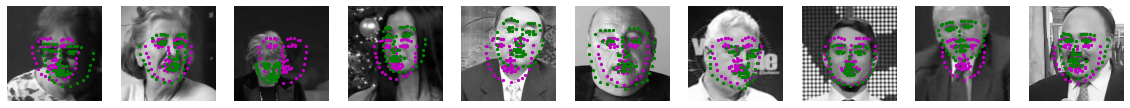

<Figure size 432x288 with 0 Axes>

In [10]:
test_images, test_outputs, gt_pts = net_sample_output(test_loader, net, device)
visualize_output(test_images, test_outputs, gt_pts, phase = 'After training Predictions')

In [9]:
PATH = 'trained_model.pth'
torch.save(net, PATH)
model = torch.load(PATH)
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Linear1): Linear(in_features=80000, out_features=512, bias=True)
  (Linear2): Linear(in_features=512, out_features=256, bias=True)
  (Linear3): Linear(in_features=256, out_features=136, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)